In [5]:
import matplotlib, time
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from numpy import pi, sqrt, ceil, array, sin, cos, tan, arctan, tanh, log, exp
from scipy import optimize
from math import erf
from qutip import (Qobj, tensor, basis, fock, ket, bra, num, qeye, destroy, fidelity, expect, ket2dm, mesolve, 
                   identity, sigmax, sigmay, sigmaz, Options, mcsolve
                  )
from qutip.visualization import plot_fock_distribution, matrix_histogram
                  
font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)
matplotlib.rcParams['xtick.direction'] = 'in'  
matplotlib.rcParams['ytick.direction'] = 'in'
np.set_printoptions(suppress=True)
from qutip.visualization import hinton
import math as math
# important settings to improve ODE solver
options = Options()
options.num_cpus=24
options.atol = 1e-18
options.rtol = 1e-15
options.order = 100
options.nsteps = 200000
import cython

In [6]:
def Rge(phi, theta):
    mat = [[cos(theta/2), -exp(-1j*phi)*sin(theta/2), 0], 
           [exp(1j*phi)*sin(theta/2), cos(theta/2), 0], 
           [0, 0, 1]]
    return Qobj(mat)
def Ref(phi, theta):
    mat = [[1, 0, 0],
           [0, cos(theta/2), -exp(-1j*phi)*sin(theta/2)], 
           [0, exp(1j*phi)*sin(theta/2), cos(theta/2)]]
    return Qobj(mat)
def step(x):
    return 1 * (x > 0)

In [7]:
def show_plot_rho(rho_MLE, rho_id=None, title1="Re[$\\rho_{MLE}$]", title2="Im[$\\rho_{MLE}$]", title3="Re[$\\rho_{ideal}$]", title4="Im[$\\rho_{ideal}$]"):
    if rho_id is None:
        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
    else:
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(223)
        ax4 = fig.add_subplot(224)
    
    labels = ["gg", "ge", "gf", "gh", "eg", "ee", "ef", "eh", "fg", "fe", "ff", "fh", "hg", "he", "hf", "hh"]
    hinton(np.round(np.real(rho_MLE),decimals=10), xlabels=labels, ylabels=labels, ax=ax1)
    hinton(np.round(np.imag(rho_MLE),decimals=10), xlabels=labels, ylabels=labels, ax=ax2)
    if rho_id is not None:
        hinton(np.round(np.real(rho_id),decimals=10), xlabels=labels, ylabels=labels, ax=ax3)
        hinton(np.round(np.imag(rho_id),decimals=10), xlabels=labels, ylabels=labels, ax=ax4)
    
    ax1.set_title(title1)
    ax2.set_title(title2)
    if rho_id is not None:
        ax3.set_title(title3)
        ax4.set_title(title4)

In [8]:
def fitgeneral(xdata, ydata, fitfunc, fitparams, domain=None, showfit=False, showstartfit=False, showdata=True,
               label="", mark_data='bo', mark_fit='r-'):
    """Uses optimize.leastsq to fit xdata ,ydata using fitfunc and adjusting fit params"""

    # sort data
    order = np.argsort(xdata)
    xdata = xdata[order]
    ydata = ydata[order]

    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
#    print 'minimum', np.min(fitdatay)
#    ymin=np.min(fitdatay)
    errfunc = lambda p, x, y: (fitfunc(p,x) - y) #there shouldn't be **2 # Distance to the target function
    startparams=fitparams # Initial guess for the parameters
    bestfitparams, success = optimize.leastsq(errfunc, startparams[:], args=(fitdatax,fitdatay))
    if showfit:
        if showdata:
            plt.plot(fitdatax,fitdatay,mark_data,label=label+" data")
        if showstartfit:
            plt.plot(fitdatax,fitfunc(startparams,fitdatax),label=label+" startfit")
        plt.plot(fitdatax,fitfunc(bestfitparams,fitdatax),mark_fit,label=label+" fit")
        if label!='': plt.legend()
        err=math.fsum(errfunc(bestfitparams,fitdatax,fitdatay))
        #print 'the best fit has an RMS of {0}'.format(err)
#    plt.t
#    plt.figtext()    
    return bestfitparams

def fitsin(xdata,ydata,fitparams=None,domain=None,showfit=False,showstartfit=False,label=""):
    """Fits sin wave of form: p[0]*np.sin(2.*pi*p[1]*x+p[2]*pi/180.)+p[3]"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
    if fitparams is None:    
        FFT=scipy.fft(fitdatay)
        fft_freqs=scipy.fftpack.fftfreq(len(fitdatay),fitdatax[1]-fitdatax[0])
        max_ind=np.argmax(abs(FFT[4:len(fitdatay)/2.]))+4
        fft_val=FFT[max_ind]
        
        fitparams=[0,0,0,0]
        fitparams[3]=np.mean(fitdatay)
        fitparams[0]=(max(fitdatay)-min(fitdatay))/2.#2*abs(fft_val)/len(fitdatay)
        fitparams[1]=fft_freqs[max_ind]
        fitparams[2]=(cmath.phase(fft_val)-np.pi/2.)*180./np.pi
        #fitparams[3]=(max(fitdatax)-min(fitdatax))
        #fitparams[5]=fitdatax[0]
        
    sin2=lambda p,x: p[0]*np.cos(2.*np.pi*p[1]*x+p[2]*np.pi/180.)+p[3]
    #print "fitparams: ",fitparams
    p1 = fitgeneral(fitdatax, fitdatay, sin2, fitparams, domain=None, showfit=showfit, showstartfit=showstartfit,
                    label=label)
    return p1  


# Defining Z phase correction and system setup

In [9]:
def ZZ(ge, ef):
    op = [[1, 0, 0,0], [0, np.exp(1j*ge/180*pi), 0,0], [0, 0, np.exp(1j*(ge+ef)/180*pi),0],[0,0,0,1]]
    op = Qobj(op)
    return op

In [10]:
w1 = 3568.1751638611518 * 2 * pi
alpha1 = -142.6213694550852 * 2 * pi
N_q = 4

# All experiment gate length
hpi1 = 0.07
pi_ef1 = 0.14
sigma = 5/1000

Age1 = 1/4/(hpi1+sqrt(2*pi)*sigma*erf(sqrt(2)))*2*pi
Aef1 = 1/2/(pi_ef1+sqrt(2*pi)*sigma*erf(sqrt(2)))/sqrt(2)*2*pi


a1 = destroy(N_q)
az1 = a1.dag()*a1
# All in us, MHz
T1_q1 = 47.9
T1_q2 = 35.1
T2_q1 = 4.5
T2_q2 = 3.2

Gamma_1q = 1/T1_q1*0
Gamma_2q = 1/T1_q2*0
Gamma_phi1 = 1/T2_q1*0
Gamma_phi2 = 1/T2_q2*0
c_ops = []
if Gamma_1q > 0:
    c_ops.append(np.sqrt(Gamma_1q) * a1)

if Gamma_phi1 > 0:
    c_ops.append(np.sqrt(Gamma_phi1) * az1)



H0 = w1*az1+alpha1/2*a1.dag()*a1.dag()*a1*a1


In [15]:
Hx1 = Age1*(a1+a1.dag())
Hx2 = Aef1*(a1+a1.dag())
wx1 = w1
wx2 = w1+alpha1
tlist1 = np.linspace(0,hpi1+4*sigma,1001)
tlist2 = np.linspace(hpi1+4*sigma, hpi1 + pi_ef1+8*sigma, 1001)
tlist3 = np.linspace(hpi1 + pi_ef1+8*sigma, hpi1+12*sigma + pi_ef1*2, 1001)
tlist4 = np.linspace(hpi1+12*sigma + pi_ef1*2, hpi1*2+16*sigma + 2*pi_ef1, 1001)
psi0 = basis(N_q, 0) # Initial state
psi0 = psi0.unit()

def fff(t, args):
    return (step(args['start']+2*args['sigma']-t)*exp(-(t-args['start']-2*args['sigma'])**2/sigma/sigma/2)+ \
            step(t-args['stop']+2*args['sigma'])*exp(-(t-args['stop']+2*args['sigma'])**2/sigma/sigma/2)+ \
           step(t-args['start']-2*args['sigma'])*step(args['stop']-2*args['sigma']-t))*cos(args['wx1']*t+args['phase'])
Ht = [H0, [Hx1, fff]]
Ht1 = [H0, [Hx2, fff]]
print('Running mesolve...')
q1_g = ket("0",N_q)*bra("0",N_q)
q1_e = ket("1",N_q)*bra("1",N_q)
q1_f = ket("2",N_q)*bra("2",N_q)

args = {'wx1': wx1, 'sigma':sigma, 'start':0, 'stop':hpi1+4*sigma, 'phase':0}
output = mesolve(Ht, psi0, tlist1, c_ops, [], args, options=options)
psi1 = output.states[-1].unit()
args = {'wx1': wx2, 'sigma':sigma, 'start':hpi1+4*sigma, 'stop':hpi1 + pi_ef1+8*sigma, 'phase':0}
output1 = mesolve(Ht1, psi1, tlist2, c_ops, [], args, options=options)
psi2 = output1.states[-1].unit()

args = {'wx1': wx2, 'sigma':sigma, 'start':hpi1 + pi_ef1+8*sigma, 'stop':hpi1+12*sigma + pi_ef1*2, 'phase':0}
output2 = mesolve(Ht1, psi2, tlist3, c_ops, [], args, options=options)
psi3 = output2.states[-1].unit()
args = {'wx1': wx1, 'sigma':sigma, 'start':hpi1+12*sigma + pi_ef1*2, 'stop':hpi1*2+16*sigma + 2*pi_ef1, 'phase':0}
output3 = mesolve(Ht, psi3, tlist4, c_ops, [], args, options=options)
psi4 = output3.states[-1].unit()

Running mesolve...


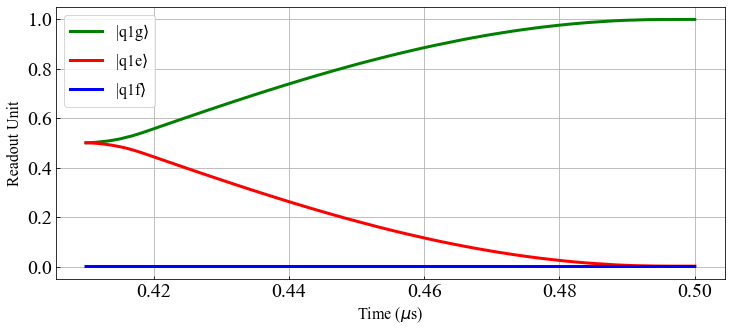

In [92]:
output_a = output3
tlist_a = tlist4

p_q1g1, p_q1e1, p_q1f1 = output_a.expect[0], output_a.expect[1], output_a.expect[2]
fig, ax = plt.subplots(1, 1, figsize=(12,5))

ax.plot(tlist_a, p_q1g1, color='green', linewidth=3, linestyle='-', marker='o', markersize=0., label=r'|q1g$\rangle$')
ax.plot(tlist_a, p_q1e1, color='red', linewidth=3, linestyle='-', marker='o', markersize=0., label=r'|q1e$\rangle$')
ax.plot(tlist_a, p_q1f1, color='blue', linewidth=3, linestyle='-', marker='o', markersize=0., label=r'|q1f$\rangle$')
ax.set_xlabel('Time ($\mu$s)')
ax.set_ylabel('Readout Unit')
ax.tick_params(labelsize=20)
plt.legend(fontsize=16, loc=2)
plt.grid()

# define RB gates

In [22]:
def run_gate(psi0, Ht, argin):
    q1_g = ket("0",N_q)*bra("0",N_q)
    q1_e = ket("1",N_q)*bra("1",N_q)
    q1_f = ket("2",N_q)*bra("2",N_q)

    tlist1 = np.linspace(argin['start1'], argin['stop1'], 1001)

    args = argin
    
    output = mesolve(Ht, psi0, tlist1, [], [], args, options=options)
    # print(output.states)
    psi1 = output.states[-1].unit()
    return psi1, output

def gate2run(psi0, instructions): 
    # convert instructions to args, start, stop, then run it, ge only do hpi, ef only do pi
    # instructions: 
        # level: ge/ef
        # phase: in rad
        # t0: current pulse time

    w1 = 3568.1751638611518 * 2 * pi
    alpha1 = -142.6213694550852 * 2 * pi
    N_q = 4

    # All experiment gate length
    hpi1 = 0.07
    pi_ef1 = 0.14
    sigma = 5/1000

    Age1 = 1/4/(hpi1+sqrt(2*pi)*sigma*erf(sqrt(2)))*2*pi
    Aef1 = 1/2/(pi_ef1+sqrt(2*pi)*sigma*erf(sqrt(2)))/sqrt(2)*2*pi

    a1 = destroy(N_q)
    az1 = a1.dag()*a1

    H0 = w1*az1+alpha1/2*a1.dag()*a1.dag()*a1*a1

    Hx1 = Age1*(a1+a1.dag())
    Hx2 = Aef1*(a1+a1.dag())
    wx1 = w1
    wx2 = w1+alpha1
    sigma = 0.005

    def fff(t, args):
        return (step(args['start1']+2*args['sigma']-t)*exp(-(t-args['start1']-2*args['sigma'])**2/sigma/sigma/2)+ \
                step(t-args['stop1']+2*args['sigma'])*exp(-(t-args['stop1']+2*args['sigma'])**2/sigma/sigma/2)+ \
            step(t-args['start1']-2*args['sigma'])*step(args['stop1']-2*args['sigma']-t))*cos(args['wx1']*t+args['phase'])
    Ht = [H0, [Hx1, fff]]
    Ht1 = [H0, [Hx2, fff]]

    args = {'wx1': wx1, 'sigma':sigma, 'start1':instructions['t0'], 'stop1':hpi1+4*sigma+instructions['t0'], 'phase':instructions['phase']}
    if instructions['level']=='ef':  # ef only do pi gate
        args['wx1'] = wx2
        args['stop1'] = instructions['t0']+pi_ef1+4*sigma        
        psi1, output = run_gate(psi0, Ht1, args)
    else:   # ge only do hpi gate
        psi1, output = run_gate(psi0, Ht, args)

    return psi1, output, args['stop1']


In [30]:
import random
## generate sequences of random pulses
## 1:Z,   2:X, 3:Y
## 4:Z/2, 5:X/2, 6:Y/2
## 7:-Z/2, 8:-X/2, 9:-Y/2
## 0:I
## Calculate inverse rotation
matrix_ref = {}
# Z, X, Y, -Z, -X, -Y
matrix_ref['0'] = np.matrix([[1, 0, 0, 0, 0, 0],
                                [0, 1, 0, 0, 0, 0],
                                [0, 0, 1, 0, 0, 0],
                                [0, 0, 0, 1, 0, 0],
                                [0, 0, 0, 0, 1, 0],
                                [0, 0, 0, 0, 0, 1]])
matrix_ref['1'] = np.matrix([[0, 0, 0, 1, 0, 0],
                                [0, 1, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0, 1],
                                [1, 0, 0, 0, 0, 0],
                                [0, 0, 0, 0, 1, 0],
                                [0, 0, 1, 0, 0, 0]])
matrix_ref['2'] = np.matrix([[0, 0, 0, 1, 0, 0],
                                [0, 0, 0, 0, 1, 0],
                                [0, 0, 1, 0, 0, 0],
                                [1, 0, 0, 0, 0, 0],
                                [0, 1, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0, 1]])
matrix_ref['3'] = np.matrix([[0, 0, 1, 0, 0, 0],
                                [0, 1, 0, 0, 0, 0],
                                [0, 0, 0, 1, 0, 0],
                                [0, 0, 0, 0, 0, 1],
                                [0, 0, 0, 0, 1, 0],
                                [1, 0, 0, 0, 0, 0]])
matrix_ref['4'] = np.matrix([[0, 0, 0, 0, 1, 0],
                                [1, 0, 0, 0, 0, 0],
                                [0, 0, 1, 0, 0, 0],
                                [0, 1, 0, 0, 0, 0],
                                [0, 0, 0, 1, 0, 0],
                                [0, 0, 0, 0, 0, 1]])
matrix_ref['5'] = np.matrix([[0, 0, 0, 0, 0, 1],
                                [0, 1, 0, 0, 0, 0],
                                [1, 0, 0, 0, 0, 0],
                                [0, 0, 1, 0, 0, 0],
                                [0, 0, 0, 0, 1, 0],
                                [0, 0, 0, 1, 0, 0]])
matrix_ref['6'] = np.matrix([[0, 1, 0, 0, 0, 0],
                                [0, 0, 0, 1, 0, 0],
                                [0, 0, 1, 0, 0, 0],
                                [0, 0, 0, 0, 1, 0],
                                [1, 0, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0, 1]])

def no2gate(no):
    g = 'I'
    if no==1:
        g = 'X'
    elif no==2:
        g = 'Y'
    elif no==3:
        g = 'X/2'
    elif no==4:
        g = 'Y/2'
    elif no==5:
        g = '-X/2'
    elif no==6:
        g = '-Y/2'  

    return g

def gate2no(g):
    no = 0
    if g=='X':
        no = 1
    elif g=='Y':
        no = 2
    elif g=='X/2':
        no = 3
    elif g=='Y/2':
        no = 4
    elif g=='-X/2':
        no = 5
    elif g=='-Y/2':
        no = 6

    return no

def generate_sequence(rb_depth, iRB_gate_no=-1, debug=False, matrix_ref=matrix_ref):
    gate_list = []
    for ii in range(rb_depth):
        gate_list.append(random.randint(1, 6))   # from 1 to 6
        if iRB_gate_no > -1:   # performing iRB
            gate_list.append(iRB_gate_no)

    a0 = np.matrix([[1], [0], [0], [0], [0], [0]]) # initial state
    anow = a0
    for i in gate_list:
        anow = np.dot(matrix_ref[str(i)], anow)
    anow1 = np.matrix.tolist(anow.T)[0]
    max_index = anow1.index(max(anow1))
    # inverse of the rotation
    inverse_gate_symbol = ['-Y/2', 'X/2', 'X', 'Y/2', '-X/2']
    if max_index == 0:
        pass
    else:
        gate_list.append(gate2no(inverse_gate_symbol[max_index-1]))
    if debug:
        print(gate_list)
        print(max_index)
    return gate_list

def sequence2instructions(gate_list, ef=True):
    # update everything except t0
    instruction_list = []
    tnow = 0
    for ii in gate_list:
        if ii==1:
            ins = {'level':'ge', 'phase':0, 't0':tnow}
            instruction_list.append(ins)
            instruction_list.append(ins)
        if ii==2:
            ins = {'level':'ge', 'phase':-np.pi/2, 't0':tnow}
            instruction_list.append(ins)
            instruction_list.append(ins)
        if ii==3:
            ins = {'level':'ge', 'phase':0, 't0':tnow}
            instruction_list.append(ins)
        if ii==4:
            ins = {'level':'ge', 'phase':-np.pi/2, 't0':tnow}
            instruction_list.append(ins)
        if ii==5:
            ins = {'level':'ge', 'phase':-np.pi, 't0':tnow}
            instruction_list.append(ins)
        if ii==6:
            ins = {'level':'ge', 'phase':np.pi/2, 't0':tnow}
            instruction_list.append(ins)

        if ef:  # ef pi, ef -pi
            ins1 = {'level':'ef', 'phase':0, 't0':tnow}
            instruction_list.append(ins1)
            ins1 = {'level':'ef', 'phase':np.pi, 't0':tnow}
            instruction_list.append(ins1)

    return instruction_list

# actual check

In [39]:
depth = 50
N_q = 4
sequence = generate_sequence(depth)
# sequence = [3,3,3,3,3]
instruction_list = sequence2instructions(sequence)
psi0 = basis(N_q, 0) # Initial state
psi0 = psi0.unit()
tnow = 0
for aa in instruction_list:
    aa['t0'] = tnow
    psi1, output1, tnow = gate2run(psi0, aa)
    psi0 = psi1

In [40]:
q1_g = ket("0",N_q)*bra("0",N_q)
q1_e = ket("1",N_q)*bra("1",N_q)
q1_f = ket("2",N_q)*bra("2",N_q)
expect(q1_g, psi0)

0.9413119800775435

In [41]:
0.9413**(1/50)

0.9987908639861619

In [26]:
psi0 = basis(N_q, 0) # Initial state
psi0 = psi0.unit()

instructions = {'level':'ge', 'phase':0, 't0':0}
psi1, output1, tnow1 = gate2run(psi0, instructions)
instructions = {'level':'ef', 'phase':0, 't0':tnow1}
psi2, output2, tnow2 = gate2run(psi1, instructions)
instructions = {'level':'ef', 'phase':np.pi, 't0':tnow2}
psi3, output3, tnow3 = gate2run(psi2, instructions)
instructions = {'level':'ge', 'phase':0, 't0':tnow3}
psi4, output4, tnow4 = gate2run(psi3, instructions)

In [29]:
psi4.unit().full()

array([[ 0.00007855+0.03697992j],
       [-0.54350009-0.83855239j],
       [-0.00696659+0.00321014j],
       [-0.00332016-0.00038471j]])